# Using CLMM on Real Datasets

_the LSST-DESC CLMM team_

This notebook can be run on NERSC.

Here we demonstrate how to run CLMM on real observational datasets. As an example, we use the data from the Dark Energy Survey (DES) public releases (DES Collaboration 2021, 2018). The catalogs can be accessed from the NOIRLab Astro Data Lab.

The steps in this notebook includes:
- [Setting things up](#Setup)
- [Selecting a cluster](#Selecting_a_cluster)
- [Downloading the published catalog at the cluster field](#Downloading_the_catalog)
- [Loading the catalog into CLMM](#Loading_the_catalog)
- [Running CLMM on the dataset](#Running_CLMM)

Acknowledgement

DES data: https://des.ncsa.illinois.edu/thanks

Astro Data Lab: https://datalab.noirlab.edu/acknowledgements.php


<a id="Setup"></a>
## 1. Setup
    
We import packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy.table import Table
import pickle as pkl
from pathlib import Path

<a id="Selecting_a_cluster"></a>
## 2. Selecting a cluster

We use the DES Y1 redMaPPer Catalogs (https://des.ncsa.illinois.edu/releases/y1a1/key-catalogs/key-redmapper) to select a list of high-richness (LAMBDA) galaxy clusters, which likely have high masses.

Name | RA (deg) | DEC (deg) | Z_LAMBDA | LAMBDA | Note
- | - | - | - | - | -
RMJ025415.5-585710.7 | 0.429804 | 43.564574 | -58.95297 | 234.50368 | --
RMJ051637.4-543001.6 | 79.155704 | -54.500456 | 0.30416065 | 195.06956 | ACO S520
RMJ224851.8-443106.3 | 342.215897 | -44.518403 | 0.3514858 | 178.83827 | --
...





## Under development

<a id="Downloading_the_catalog"></a>
## 3. Downloading the catalog at the cluster field

The 3 most massive cluster-candidates are MaxBCG J140.53188+03.76632 (in the GAMA09H field), Miyazaki+2018 (M18 hearafter) rank 48 and 62 (in the GAMA15H field). We consider MaxBCG J140.53188+03.76632 first.
The webpage for HSC SSP data access is here [link](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).
To download the catalogs, we need to first register for a user account ([link](https://hsc-release.mtk.nao.ac.jp/datasearch/new_user/new)).
Then we log into the system, query and download the catalogs at [CAS Search](https://hsc-release.mtk.nao.ac.jp/datasearch/helps/sql_search); we use `object_id` to cross match the shape catalog, photo-z catalog, and photometry catalog. 
Since the clusters are at redshift about 0.4, a radius of 10 arcmin would be about 3 Mpc. However, we make a query for the whole field to save time.
The final catalog includes shape info, photo-z, and photometry. 
Here is an example of the query SQL command (thank Calum Murray; [example command](https://hsc-release.mtk.nao.ac.jp/doc/index.php/s16a-shape-catalog-pdr2/); [schema](https://hsc-release.mtk.nao.ac.jp/schema/)); the query could take 1 hour and the size of the catalog could be 400 MB (.csv.gz). If you would like to test it, please copy from "select" to "--LIMIT 5". Also select "PDR1" or press "Guess release from your SQL" at the [CAS Search](https://hsc-release.mtk.nao.ac.jp/datasearch/helps/sql_search) webpage.
To unpress the file "*.gz", use "gunzip" or "gzip -d".

```
select
 b.*, 
 c.ira, c.idec, 
 a.ishape_hsm_regauss_e1, a.ishape_hsm_regauss_e2, 
 a.ishape_hsm_regauss_resolution, a.ishape_hsm_regauss_sigma, 
 d1.photoz_best as ephor_ab_photoz_best, d1.photoz_risk_best as ephor_ab_photoz_risk_best, 
 d2.photoz_best as frankenz_photoz_best, d2.photoz_risk_best as frankenz_photoz_risk_best, 
 d3.photoz_best as nnpz_photoz_best, d3.photoz_risk_best as nnpz_photoz_risk_best, 
 e.icmodel_mag, e.icmodel_mag_err, 
 e.detect_is_primary, 
 e.iclassification_extendedness, 
 e.icmodel_flux_flags, 
 e.icmodel_flux, e.icmodel_flux_err, 
 c.iblendedness_abs_flux
from
 s16a_wide.meas2 a
 inner join s16a_wide.weaklensing_hsm_regauss b using (object_id)
 inner join s16a_wide.meas c using (object_id)
 -- inner join s16a_wide.photoz_demp d using (object_id)
 -- inner join s16a_wide.photoz_ephor d using (object_id)
  inner join s16a_wide.photoz_ephor_ab d1 using (object_id)
  inner join s16a_wide.photoz_frankenz d2 using (object_id)
 -- inner join s16a_wide.photoz_mizuki d using (object_id)
 -- inner join s16a_wide.photoz_mlz d using (object_id)
  inner join s16a_wide.photoz_nnpz d3 using (object_id)
  inner join s16a_wide.forced e using (object_id)
-- Uncomment the specific lines depending upon the field to be used
 -- where s16a_wide.search_xmm(c.skymap_id)
 -- where s16a_wide.search_wide01h(c.skymap_id)
 -- where s16a_wide.search_vvds(c.skymap_id)
 -- where s16a_wide.search_hectomap(c.skymap_id)
 -- where s16a_wide.search_gama15h(c.skymap_id)
 where s16a_wide.search_gama09h(c.skymap_id)
 --AND e.detect_is_primary
 --AND conesearch(c.icoord, 140.54565, 3.77820, 600) 
 --AND NOT e.icmodel_flux_flags
 --AND e.iclassification_extendedness>0.5
 --LIMIT 5
```


<a id="Loading_the_catalog"></a>
## 4. Loading the catalog into CLMM

Once we have the catalog, we read in the catalog, make cuts on the catalog, and adjust column names to prepare for the analysis in CLMM.




In [4]:
%%time
# Assume the downloaded catalog is at this path:
filename = "../../../197376_GAMMA09H.csv"
catalog = filename.replace('.csv', '.pkl')
if not Path(catalog).is_file():
    data_0 = Table.read(filename, format="ascii.csv")
    pkl.dump(data_0, open(catalog,"wb"))
else:
    data_0 = pkl.load(open(catalog,"rb"))

CPU times: user 8.06 s, sys: 13.8 s, total: 21.9 s
Wall time: 25.5 s


In [5]:
print(data_0.colnames)

['# object_id', 'ishape_hsm_regauss_derived_shape_weight', 'ishape_hsm_regauss_derived_shear_bias_m', 'ishape_hsm_regauss_derived_shear_bias_c1', 'ishape_hsm_regauss_derived_shear_bias_c2', 'ishape_hsm_regauss_derived_sigma_e', 'ishape_hsm_regauss_derived_rms_e', 'ira', 'idec', 'ishape_hsm_regauss_e1', 'ishape_hsm_regauss_e2', 'ishape_hsm_regauss_resolution', 'ishape_hsm_regauss_sigma', 'ephor_ab_photoz_best', 'ephor_ab_photoz_risk_best', 'frankenz_photoz_best', 'frankenz_photoz_risk_best', 'nnpz_photoz_best', 'nnpz_photoz_risk_best', 'icmodel_mag', 'icmodel_mag_err', 'detect_is_primary', 'iclassification_extendedness', 'icmodel_flux_flags', 'icmodel_flux', 'icmodel_flux_err', 'iblendedness_abs_flux']


In [6]:
# We select "frankenz" for the test, but there are other methods available.
photoz_type = "frankenz"
#photoz_type = "nnpz"
#photoz_type = "ephor_ab"

In [7]:
# Cuts
def make_cuts(catalog_in):
    # We consider some cuts in Mandelbaum et al. 2018 (HSC SSP Y1 shear catalog).
    select = catalog_in["detect_is_primary"] == "True"
    select &= catalog_in["icmodel_flux_flags"] == "False"
    select &= catalog_in["iclassification_extendedness"] > 0.5
    select &= catalog_in["icmodel_mag_err"] <= 2.5/np.log(10.)/10.
    select &= catalog_in["ishape_hsm_regauss_e1"]**2 + catalog_in["ishape_hsm_regauss_e2"]**2 < 4.
    select &= catalog_in["icmodel_mag"] <= 24.5
    select &= catalog_in["iblendedness_abs_flux"] < (10 ** (-0.375))
    select &= catalog_in["ishape_hsm_regauss_resolution"] >= 0.3 #similar to extendedness
    select &= catalog_in["ishape_hsm_regauss_sigma"] <= 0.4
    # Note "zbest" minimizes the risk of the photo-z point estimate being far away from the true value.
    # Details: https://hsc-release.mtk.nao.ac.jp/doc/wp-content/uploads/2017/02/pdr1_photoz_release_note.pdf
    select &= catalog_in["%s_photoz_risk_best"%photoz_type] < 0.5
    
    catalog_out = catalog_in[select]
    
    return catalog_out

data_1 = make_cuts(data_0)
print(len(data_0), len(data_1), len(data_1)*1./len(data_0))

2678766 2514470 0.9386672818753112


In [8]:
# Reference: Mandelbaum et al. 2018 "The first-year shear catalog of the Subaru Hyper Suprime-Cam Subaru Strategic Program Survey".
# Section A.3.2: "per-object galaxy shear estimate".
def apply_shear_calibration(catalog_in):
    e1_0 = catalog_in["ishape_hsm_regauss_e1"]
    e2_0 = catalog_in["ishape_hsm_regauss_e2"]
    e_rms = catalog_in["ishape_hsm_regauss_derived_rms_e"]
    m = catalog_in["ishape_hsm_regauss_derived_shear_bias_m"]
    c1 = catalog_in["ishape_hsm_regauss_derived_shear_bias_c1"]
    c2 = catalog_in["ishape_hsm_regauss_derived_shear_bias_c2"]
    # Note: in the mass fit we have not implemented the weight yet.
    weight = catalog_in["ishape_hsm_regauss_derived_shape_weight"]
    
    R = 1. - np.sum(weight * e_rms ** 2.)/np.sum(weight)
    m_mean = np.sum(weight * m)/np.sum(weight)
    c1_mean = np.sum(weight * c1)/np.sum(weight)
    c2_mean = np.sum(weight * c2)/np.sum(weight)
    print("R, m_mean, c1_mean, c2_mean: ", R, m_mean, c1_mean, c2_mean)
    
    g1 = ( e1_0 / (2. * R) - c1 ) / (1. + m_mean)
    g2 = ( e2_0 / (2. * R) - c2 ) / (1. + m_mean)
    
    return g1, g2


In [9]:
# Adjust column names.
def adjust_column_names(catalog_in):
    # We consider a map between new and old column names.
    # Note we have considered shear calibration here.
    column_name_map = {
        "ra": "ira",
        "dec": "idec",
        'z': "%s_photoz_best"%photoz_type, 
        "id": "# object_id",
    }
    
    catalog_out = Table()
    for i in column_name_map:
        catalog_out[i] = catalog_in[column_name_map[i]]
    
    g1, g2 = apply_shear_calibration(catalog_in)
    # CLMM uses "epsilon shape" rather than "chi shape".
    catalog_out["e1"] = g1 
    catalog_out["e2"] = g2 
    
    return catalog_out

data_2 = adjust_column_names(data_1)

R, m_mean, c1_mean, c2_mean:  0.840031677829739 -0.10973213380132621 -0.0001494161260923776 1.7902495719644782e-05


In [10]:
# Make some figures for visualization.
def make_plots(catalog_in):
    # Scatter plot
    plt.figure()
    plt.scatter(catalog_in["ra"], catalog_in["dec"], c=catalog_in['z'], s=1., alpha=0.2)
    plt.colorbar()
    plt.xlabel("ra")
    plt.ylabel("dec")
    plt.title("z")
    
    # Histogram
    plt.figure()
    plt.hist(catalog_in['z'], bins=20)
    plt.xlabel('z')
    plt.ylabel("count")
    
    # Relation
    plt.figure()
    plt.plot(catalog_in["e1"], catalog_in["e2"], ',')
    plt.xlabel("e1")
    plt.ylabel("e2")

#make_plots(data_2)

<a id="Running_CLMM"></a>
## 5. Running CLMM on the dataset
We use the functions similar to `examples/Paper_v1.0/gt_and_use_case.ipynb`.

In [11]:
from clmm import Cosmology
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

# We consider MaxBCG J140.53188+03.76632
cluster_z = 0.2701 # Cluster redshift
cluster_ra = 140.54565 # Cluster Ra in deg
cluster_dec = 3.77820 # Cluster Dec in deg

obs_galaxies = data_2
 
obs_galaxies = obs_galaxies[(obs_galaxies['z']>(cluster_z+0.1))]

# Area cut: the query is made for the whole field and this can simplify the processing.
select = obs_galaxies['ra'] < cluster_ra + 12./60./np.cos(cluster_dec/180.*np.pi)
select &= obs_galaxies['ra'] > cluster_ra - 12./60./np.cos(cluster_dec/180.*np.pi)
select &= obs_galaxies['dec'] < cluster_dec + 12./60.
select &= obs_galaxies['dec'] > cluster_dec - 12./60.
obs_galaxies = obs_galaxies[select]

obs_galaxies['id'] = np.arange(len(obs_galaxies))

# Put galaxy values on arrays.
gal_ra = obs_galaxies['ra'] # Galaxies Ra in deg
gal_dec = obs_galaxies['dec'] # Galaxies Dec in deg
gal_e1 = obs_galaxies['e1'] # Galaxies elipticipy 1
gal_e2 = obs_galaxies['e2'] # Galaxies elipticipy 2
gal_z = obs_galaxies['z'] # Galaxies observed redshift
gal_id = obs_galaxies['id'] # Galaxies ID

In [12]:
# Shear profile
# Using/testing clmm.dataops functions (details are in the notebook for Paper V1.0).
# This step is for testing the CLMM functionalities; we will not use the result in later steps.

import clmm.dataops as da
# Convert elipticities into shears.
gal_ang_dist, gal_gt, gal_gx = da.compute_tangential_and_cross_components(cluster_ra, cluster_dec,
                                                                          gal_ra, gal_dec,
                                                                          gal_e1, gal_e2,
                                                                          )

# Measure profile.
field_size = 6 # Mpc box size

profile = da.make_radial_profile([gal_gt, gal_gx, gal_z],
                                 gal_ang_dist, "radians", "Mpc",
                                 bins=da.make_bins(0.01, field_size/2., 50),
                                 cosmo=cosmo,
                                 z_lens=cluster_z,
                                 include_empty_bins=False)
print(f'Profile table has columns: {", ".join(profile.colnames)},')
print('where p_(0, 1, 2) = (gt, gx, z)')

Profile table has columns: radius_min, radius, radius_max, p_0, p_0_err, p_1, p_1_err, p_2, p_2_err, n_src,
where p_(0, 1, 2) = (gt, gx, z)


In [13]:
# Using the GalaxyCluster object.

import clmm
from clmm.utils import convert_units

# Create a GCData with the galaxies.
galaxies = clmm.GCData([gal_ra, gal_dec, gal_e1, gal_e2, gal_z, gal_id],
                      names=['ra', 'dec', 'e1', 'e2', 'z', 'id'])

# Create a GalaxyCluster.
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec,
                                   cluster_z, galaxies)

# Convert elipticities into shears for the members.
cluster.compute_tangential_and_cross_components()
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat['theta'], 'radians', 'Mpc', cluster.z, cosmo)

cluster.make_radial_profile(bins=da.make_bins(0.3, field_size/2., 15, method='evenlog10width'),
                            bin_units="Mpc",
                            cosmo=cosmo,
                            include_empty_bins=False,
                            gal_ids_in_bins=True,
                           )
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'gal_id']


[3.543307086614173, 3.543307086614173]


<Figure size 432x288 with 0 Axes>

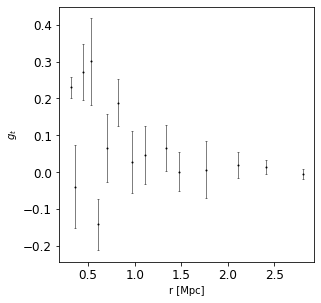

In [14]:
import sys
sys.path.append('Paper_v1.0')
from paper_formating import prep_plot
fig = prep_plot(figsize=(9, 9))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle='', marker='o',
    markersize=1, elinewidth=.5, capthick=.5)
ax.errorbar(cluster.profile['radius'], cluster.profile['gt'],
             cluster.profile['gt_err'], c='k', **errorbar_kwargs)
ax.set_xlabel('r [Mpc]', fontsize = 10)
ax.set_ylabel(r'$g_t$', fontsize = 10)
plt.show()

In [15]:
# Theoretical predictions

# Model relying on the overall redshift distribution of the sources (WtG III Applegate et al. 2014).
# Note the concentration of MaxBCG J140.53188+03.76632 was not reported.
# The value from the stacked sample in the paper is ~7.
# For the mass scale, a typical c-M relation (e.g. Child et al. 2018) would give c~3 though.
# And we have not considered a c-M relation in the fitting.
z_inf = 1000
dl_inf = cosmo.eval_da_z1z2(cluster_z, z_inf)
d_inf = cosmo.eval_da(z_inf)
concentration = 4.

def betas(z):
    dls = cosmo.eval_da_z1z2(cluster_z, z)
    ds = cosmo.eval_da(z)
    return dls * d_inf / (ds * dl_inf)

def predict_reduced_tangential_shear_redshift_distribution(profile, logm):

    bs_mean = np.mean(betas(cluster.galcat['z'])) 
    bs2_mean = np.mean(betas(cluster.galcat['z'])**2)

    gamma_t_inf = clmm.compute_tangential_shear(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=concentration, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            massdef='critical', # For M200c
            halo_profile_model='nfw')
    convergence_inf = clmm.compute_convergence(
            r_proj=profile['radius'], # Radial component of the profile
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=concentration, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            z_source=z_inf, # Redshift value at infinity
            cosmo=cosmo,
            delta_mdef=200,
            massdef='critical',
            halo_profile_model='nfw')
        
    return bs_mean*gamma_t_inf/(1-(bs2_mean/bs_mean)*convergence_inf)


# Model using individual redshift and radial information, to compute the averaged shear in each radial bin, based on the galaxies actually present in that bin.
cluster.galcat['theta_mpc'] = convert_units(cluster.galcat['theta'], 'radians', 'mpc',cluster.z, cosmo)

def predict_reduced_tangential_shear_individual_redshift(profile, logm):
    return np.array([np.mean(
        clmm.compute_reduced_tangential_shear(
            # Radial component of each source galaxy inside the radial bin
            r_proj=cluster.galcat[radial_bin['gal_id']]['theta_mpc'],
            mdelta=10**logm, # Mass of the cluster [M_sun]
            cdelta=concentration, # Concentration of the cluster
            z_cluster=cluster_z, # Redshift of the cluster
            # Redshift value of each source galaxy inside the radial bin
            z_source=cluster.galcat[radial_bin['gal_id']]['z'],
            cosmo=cosmo,
            delta_mdef=200,
            massdef='critical',
            halo_profile_model='nfw'
        )) for radial_bin in profile])


In [16]:
# Mass fitting

mask_for_fit = cluster.profile['n_src'] > 2
data_for_fit = cluster.profile[mask_for_fit]

from clmm.support.sampler import fitters
def fit_mass(predict_function):
    popt, pcov = fitters['curve_fit'](predict_function,
        data_for_fit, 
        data_for_fit['gt'], 
        data_for_fit['gt_err'], bounds=[10.,17.])
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [17]:
# In the paper, the measured mass is 44.3 {+ 30.3} {- 19.9} * 10^14 Msun (M200c,WL). 
# For convenience, we consider a mean value for the errorbar. 
# We build a dictionary based on that result.
m_paper = 44.3e14
m_err_paper = 25.1e14
logm_paper = np.log10(m_paper)
logm_err_paper = m_err_paper/(10**logm_paper)/np.log(10)
paper_value = {'logm':logm_paper, 'logm_err':logm_err_paper,
            'm': 10**logm_paper, 'm_err': (10**logm_paper)*logm_err_paper*np.log(10)}

In [18]:
%%time
fit_redshift_distribution = fit_mass(predict_reduced_tangential_shear_redshift_distribution)
fit_individual_redshift = fit_mass(predict_reduced_tangential_shear_individual_redshift)

CPU times: user 960 ms, sys: 15.4 ms, total: 976 ms
Wall time: 957 ms


In [19]:
print(f'Best fit mass for N(z) model                     = {fit_redshift_distribution["m"]:.3e} +/- {fit_redshift_distribution["m_err"]:.3e} Msun')
print(f'Best fit mass for individual redshift and radius = {fit_individual_redshift["m"]:.3e} +/- {fit_individual_redshift["m_err"]:.3e} Msun')

Best fit mass for N(z) model                     = 2.110e+15 +/- 4.237e+14 Msun
Best fit mass for individual redshift and radius = 2.358e+15 +/- 4.764e+14 Msun


In [20]:
# Visualization of the results.
def get_predicted_shear(predict_function, fit_values):
    gt_est = predict_function(data_for_fit, fit_values['logm'])
    gt_est_err = [predict_function(data_for_fit, fit_values['logm']+i*fit_values['logm_err'])
                          for i in (-3, 3)]
    return gt_est, gt_est_err

gt_redshift_distribution, gt_err_redshift_distribution =  get_predicted_shear(predict_reduced_tangential_shear_redshift_distribution, fit_redshift_distribution)
gt_individual_redshift, gt_err_individual_redshift =  get_predicted_shear(predict_reduced_tangential_shear_individual_redshift, fit_individual_redshift)

gt_paper1, gt_err_paper1 = get_predicted_shear(predict_reduced_tangential_shear_redshift_distribution, paper_value)
gt_paper2, gt_err_paper2 = get_predicted_shear(predict_reduced_tangential_shear_individual_redshift, paper_value)

In [21]:
chi2_redshift_distribution_dof = np.sum((gt_redshift_distribution-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)
chi2_individual_redshift_dof = np.sum((gt_individual_redshift-data_for_fit['gt'])**2/(data_for_fit['gt_err'])**2)/(len(data_for_fit)-1)

print(f'Reduced chi2 (N(z) model) = {chi2_redshift_distribution_dof}')
print(f'Reduced chi2 (individual (R,z) model) = {chi2_individual_redshift_dof}')

Reduced chi2 (N(z) model) = 2.4530026509176
Reduced chi2 (individual (R,z) model) = 2.6209850216326234


[3.543307086614173, 3.543307086614173]


<Figure size 1800x1200 with 0 Axes>

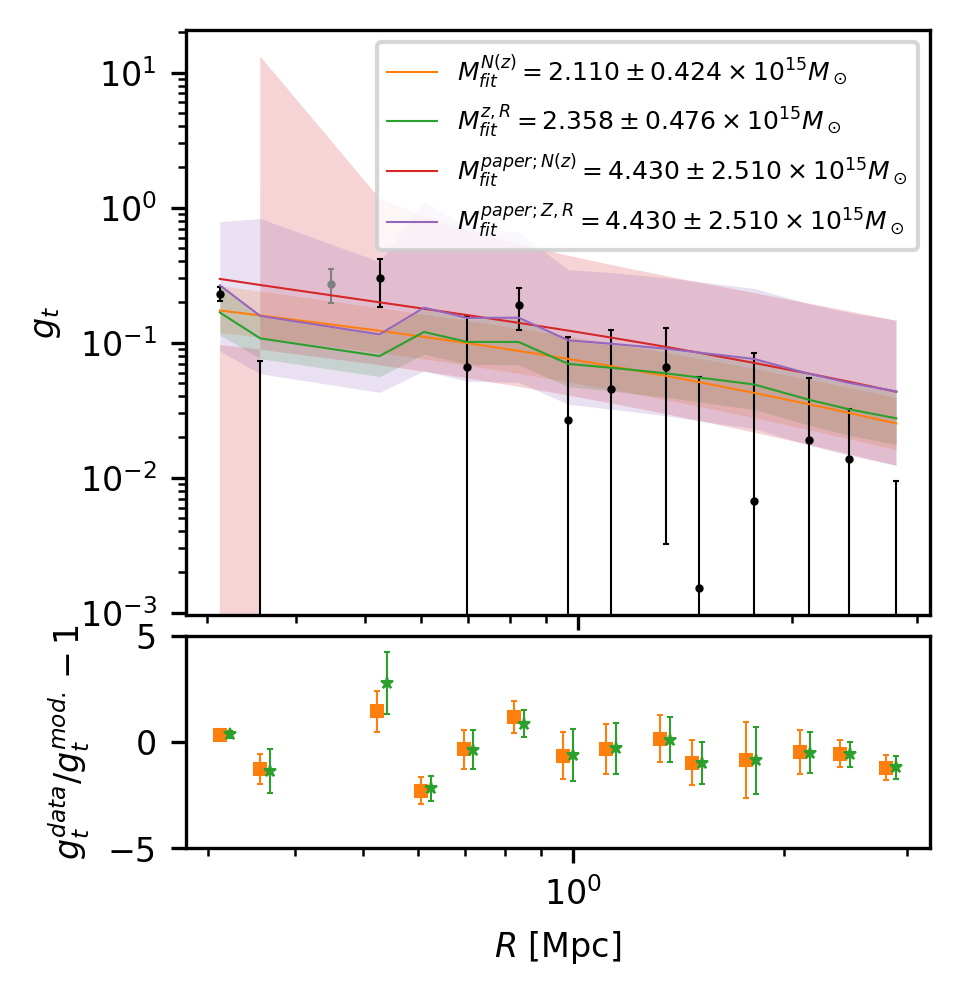

In [22]:
from matplotlib.ticker import MultipleLocator
fig = prep_plot(figsize=(9 , 9))
gt_ax = fig.add_axes((.25, .42, .7, .55))
gt_ax.errorbar(data_for_fit['radius'],data_for_fit['gt'], data_for_fit['gt_err'],
             c='k',
            **errorbar_kwargs)

# Points in grey have not been used for the fit.
gt_ax.errorbar(cluster.profile['radius'][~mask_for_fit], cluster.profile['gt'][~mask_for_fit],
               cluster.profile['gt_err'][~mask_for_fit], 
               c='grey',**errorbar_kwargs)

pow10 = 15
mlabel = lambda name, fits: fr'$M_{{fit}}^{{{name}}} = {fits["m"]/10**pow10:.3f}\pm{fits["m_err"]/10**pow10:.3f}\times 10^{{{pow10}}} M_\odot$'

# The model for the 1st method.
gt_ax.loglog(data_for_fit['radius'], gt_redshift_distribution,'-C1', 
           label=mlabel('N(z)', fit_redshift_distribution),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_redshift_distribution, lw=0, color='C1', alpha=.2)

# The model for the 2nd method.
gt_ax.loglog(data_for_fit['radius'], gt_individual_redshift,'-C2', 
           label=mlabel('z,R', fit_individual_redshift),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_individual_redshift, lw=0, color='C2', alpha=.2)

# The value in the reference paper.
gt_ax.loglog(data_for_fit['radius'], gt_paper1,'-C3', 
           label=mlabel('paper; N(z)', paper_value),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_paper1, lw=0, color='C3', alpha=.2)

gt_ax.loglog(data_for_fit['radius'], gt_paper2,'-C4', 
           label=mlabel('paper; Z,R', paper_value),
             lw=.5)
gt_ax.fill_between(data_for_fit['radius'], *gt_err_paper2, lw=0, color='C4', alpha=.2)

gt_ax.set_ylabel(r'$g_t$', fontsize = 8)
gt_ax.legend(fontsize=6)
gt_ax.set_xticklabels([])
gt_ax.tick_params('x', labelsize=8)
gt_ax.tick_params('y', labelsize=8)


errorbar_kwargs2 = {k:v for k, v in errorbar_kwargs.items() if 'marker' not in k}
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5
res_ax = fig.add_axes((.25, .2, .7, .2))
delta = (cluster.profile['radius'][1]/cluster.profile['radius'][0])**.25


res_ax.errorbar(data_for_fit['radius'], data_for_fit['gt']/gt_redshift_distribution-1,
                yerr=data_for_fit['gt_err']/gt_redshift_distribution, marker='s', c='C1', **errorbar_kwargs2)
errorbar_kwargs2['markersize'] = 3
errorbar_kwargs2['markeredgewidth'] = .5

res_ax.errorbar(data_for_fit['radius']*delta, data_for_fit['gt']/gt_individual_redshift-1,
                yerr=data_for_fit['gt_err']/gt_individual_redshift, marker='*', c='C2', **errorbar_kwargs2)
res_ax.set_xlabel(r'$R$ [Mpc]', fontsize = 8)

res_ax.set_ylabel(r'$g_t^{data}/g_t^{mod.}-1$', fontsize = 8)
res_ax.set_xscale('log')

res_ax.set_ylim(-5,5)
res_ax.yaxis.set_minor_locator(MultipleLocator(10))

res_ax.tick_params('x', labelsize=8)
res_ax.tick_params('y', labelsize=8)
plt.show()


### Reference

Aihara, H., Arimoto, N., Armstrong, R., et al. 2018, Publications of the Astronomical Society of Japan, 70, S4

Aihara, H., Armstrong, R., Bickerton, S., et al. 2018, Publications of the Astronomical Society of Japan, 70, S8

Aihara, H., AlSayyad, Y., Ando, M., et al. 2019, Publications of the Astronomical Society of Japan, 71

Hamana, T., Shirasaki, M., Lin, Y.-T., 2020, Publications of the Astronomical Society of Japan, 72, 78

Mandelbaum, R., Miyatake, H., Hamana, T., et al. 2018, Publications of the Astronomical Society of Japan, 70, S25

Mandelbaum, R., Lanusse, F., Leauthaud, A., et al. 2018, Monthly Notices of the Royal Astronomical Society, 481, 3170

Medezinski, E., Battaglia, N., Umetsu, K., et al., 2018, Publications of the Astronomical Society of Japan, 70, S28

Miyazaki, S., Oguri, M., Hamana, T., et al., 2018, Publications of the Astronomical Society of Japan, 70, S27

Umetsu, K., Sereno, M., Lieu, M., et al., 2020, Astrophysical Journal, 890, 148



